In [1]:
from scipy.io import netcdf
import numpy
import netCDF4
import pandas
import aacgmv2
import xarray
import feather
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ampFName = "../data/20110608.0000.86400.120.north.grd.ncdf"
startDate = datetime.datetime( 2011, 6, 8, 4, 0 )
selDate = datetime.datetime( 2011, 6, 8, 4, 20 )
endDate = datetime.datetime( 2011, 6, 8, 7, 0 )
delTime = datetime.timedelta(minutes=2)
coords = "mlt"
plotMlatRange = [ 55., 70. ]
# Max/Min latitude at which you expect 
# to find downward FACs associated with SCW
scwDownMlatRange = [ 55, 62. ]

In [3]:
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-06-08,2011-06-08 00:10:00,89.0,0.0,147.089996,30.629999,143.679993,43.900002,29.889999,-0.02
1,2011-06-08,2011-06-08 00:10:00,88.0,0.0,159.339996,31.719999,154.250000,51.009998,24.180000,-0.09
2,2011-06-08,2011-06-08 00:10:00,87.0,0.0,158.559998,25.010000,153.210007,47.889999,4.960000,-0.13
3,2011-06-08,2011-06-08 00:10:00,86.0,0.0,140.130005,15.470000,135.770004,37.970001,-23.920000,-0.13
4,2011-06-08,2011-06-08 00:10:00,85.0,0.0,111.970001,5.390000,109.360001,24.600000,-53.520000,-0.12


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


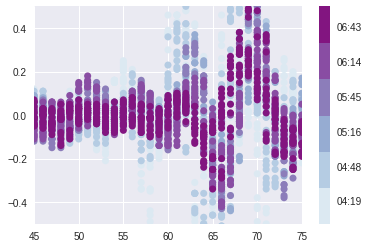

In [4]:
seaMap = ListedColormap(sns.color_palette("BuPu"))
selMlt = 22.

fig = plt.figure()
ax = fig.add_subplot(111)

selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == selMlt) & (numpy.abs(ampDF["Jr"])>=0.)) ]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]#selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=50,c=selDF['time'],
                  edgecolors='none', marker='o', cmap=seaMap) 
ax.set_xlim( [45, 75] )
ax.set_ylim( [-0.5, 0.5] )
cb = fig.colorbar(smap, orientation='vertical')
# ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
cb.formatter = DateFormatter('%H:%M')
cb.update_ticks()
# cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))
fig.savefig( "../plots/mltAmpTime-20110608.pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


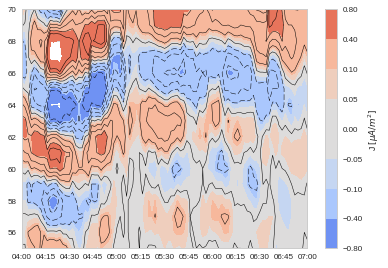

In [5]:
# Some temp constants
plotMltChsn = 22
plotJrCutoff = 0.0
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
# set a few standard xticks
xTickList = []
currTime = startDate
while currTime <= endDate:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data

fig.savefig( "../plots/scw-20110608.pdf",bbox_inches='tight' )

In [6]:
mltSCWList = [ 20., 21., 22., 23., 0., 1. ]
# jr Cutoff
jrSCWCutoff = 0.0
# MLAT Limit
mlatSCWRng = [ 55., 65. ]

# We'll take a simple approach to determine 
# We'll determine the largest positive current
# value between 50 and 70 MLAT (at a few selected
# MLTs). This should be upward R2 FAC. Then largest 
# downward FAC equatorward of this value is the peak
# of downward component of the SCW!

scwLocDates = []
scwLocMlatDown = []
scwLocMlatUp = []
scwMLTDown = []
scwMLTUp = []
scwJrDown = []
scwJrUp = []

currDate = startDate
while currDate <= endDate:
    currMinJr = 0.
    currMaxJr = 0.
    currMinMlat = 0.
    currMaxMlat = 0.
    currMinMLT = 0.
    currMaxMLT = 0.
    for cMlt in mltSCWList:
        selDF = ampDF[ ( (ampDF["start_date"] == currDate) &\
                        (numpy.abs(ampDF["Jr"])>=jrSCWCutoff) &\
                       (ampDF["mlt"] == cMlt) &\
                   (ampDF["mlat"] >= mlatSCWRng[0]) &\
                        (ampDF["mlat"] <= mlatSCWRng[1])) ]\
                [ ["start_date", "mlat", "mlt", "Jr"] ].reset_index(drop=True)
        if selDF.shape[0] == 0:
            print "no data found selDF"
            continue
#         if currDate == selDate:
#         print currDate, cMlt
        maxUpJrMlt = selDF.ix[ selDF["Jr"].idxmax() ]["mlt"]
        maxUpJrMlat = selDF.ix[ selDF["Jr"].idxmax() ]["mlat"]
        maxUpJrVal = selDF.ix[ selDF["Jr"].idxmax() ]["Jr"]
#         print "---------------------------"
#         print maxUpJrMlt,maxUpJrMlat,maxUpJrVal
        scwDownDF = selDF[ selDF["mlat"] < maxUpJrMlat ]
        if scwDownDF.shape[0] == 0:
            print "no data found selDF"
            continue
        minDownSCWMlat = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlat"]
        minDownSCWJr = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["Jr"]
        minDownSCWMlt = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlt"]
        if minDownSCWJr > 0.:
            print "postive val found for Jscw down, discarding!"
            continue
        if ( (minDownSCWMlat > scwDownMlatRange[1]) | (minDownSCWMlat < scwDownMlatRange[0]) ) :
            print "downward scw FACs location may not be good, skipping"
            continue
#         print minDownSCWMlt,minDownSCWMlat,minDownSCWJr
        scwLocDates.append( currDate )
        scwLocMlatDown.append( minDownSCWMlat )
        scwLocMlatUp.append( maxUpJrMlat )
        scwMLTDown.append( minDownSCWMlt )
        scwMLTUp.append( maxUpJrMlt )
        scwJrDown.append( minDownSCWJr )
        scwJrUp.append( maxUpJrVal )
    currDate += delTime
    
# convert fit results to a dataframe
ampSCWDF = pandas.DataFrame(
     {'scwLocDates': scwLocDates,
     'scwLocMlatDown': scwLocMlatDown,
     'scwLocMlatUp': scwLocMlatUp,
     'scwMLTDown': scwMLTDown,
     'scwMLTUp': scwMLTUp,
     'scwJrDown': scwJrDown,
     'scwJrUp': scwJrUp,
    })
# Discard zero vals (those which were initiated)
# but never used
ampSCWDF = ampSCWDF[ ampSCWDF["scwLocMlatDown"] > 0.].reset_index(drop=True)
# write results to dataframe
feather.write_dataframe(ampSCWDF, '../data/amp-scw-' +\
                startDate.strftime("%Y%m%d") + '.feather')

downward scw FACs location may not be good, skipping
no data found selDF
no data found selDF
no data found selDF
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
no data found selDF
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
no data found selDF
no data found selDF
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found

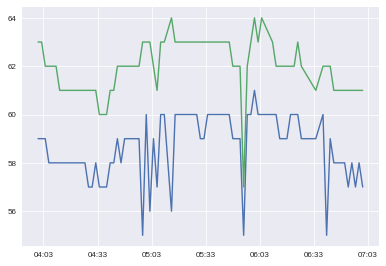

In [7]:
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
# plot
pltSCWDF = ampSCWDF[ ampSCWDF["scwMLTDown"] == 22 ]
# figure
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot( pltSCWDF['scwLocDates'].values, numpy.abs(pltSCWDF['scwLocMlatDown'].values) )
ax.plot( pltSCWDF['scwLocDates'].values, pltSCWDF['scwLocMlatUp'].values )
# ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'o' )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
# fig1.savefig("../plots/amp-ts-20110608.pdf",bbox_inches='tight')

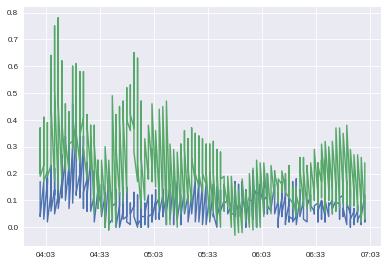

In [8]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
ax.plot( ampSCWDF['scwLocDates'].values, numpy.abs(ampSCWDF['scwJrDown'].values) )
ax.plot( ampSCWDF['scwLocDates'].values, ampSCWDF['scwJrUp'].values )
# ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'o' )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
fig1.savefig("../plots/amp-ts-20110608.pdf",bbox_inches='tight')

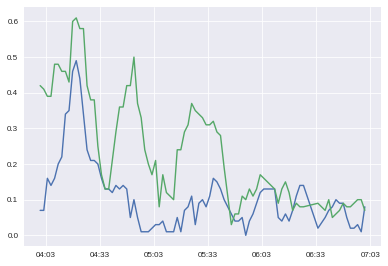

In [9]:
pltSCWDF = ampSCWDF[ ampSCWDF["scwMLTDown"] == 22 ]
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
# figure
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot( pltSCWDF['scwLocDates'].values, numpy.abs(pltSCWDF['scwJrDown'].values) )
ax.plot( pltSCWDF['scwLocDates'].values, pltSCWDF['scwJrUp'].values )
# ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'o' )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
# fig1.savefig("../plots/amp-ts-20110608.pdf",bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


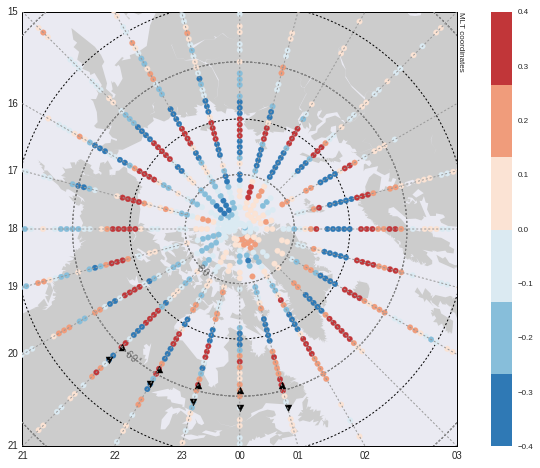

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)

seaMap = ListedColormap(sns.color_palette("RdBu_r"))

plotAmpDF = ampDF[ (ampDF["start_date"] == selDate) &\
                 (numpy.abs(ampDF["Jr"]) >= 0.05) ]

# plotAmpDF = plotAmpDF[ ["mlt", "mlat",\
#                         "Jr"] ].pivot( "mlt", "mlat" )
# mltVals = plotAmpDF.index.values*15.
# mlatVals = plotAmpDF.columns.levels[1].values
# mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )



mapHandle = utils.plotUtils.mapObj(boundinglat=50., coords=coords, lat_0=90., lon_0=0, datetime=selDate)
parallels = numpy.arange(0.,81,10.)
mapHandle.drawparallels(parallels)
# xVecs, yVecs = mapHandle(mltCntr, mlatCntr, coords=coords)
xVecs, yVecs = mapHandle(plotAmpDF["mlt"].values*15., plotAmpDF["mlat"].values, coords=coords)
ampPlot = mapHandle.scatter( xVecs, yVecs, c=plotAmpDF["Jr"].values, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )
# ampPlot = mapHandle.contourf( xVecs, yVecs, plotAmpDF["Jr"].values.T, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )

##### PLOT SCW ####
##### PLOT SCW ####
scwDwnMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwLocMlatDown"].values
scwDwnMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwMLTDown"].values
scwUpMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwLocMlatUp"].values
scwUpMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwMLTUp"].values

xVecDwn, yVecDwn = mapHandle(scwDwnMLT*15., scwDwnMlat, coords=coords)
xVecUp, yVecUp = mapHandle(scwUpMLT*15., scwUpMlat, coords=coords)

mapHandle.scatter( xVecDwn, yVecDwn, marker='v', s=50, c='k', ax=ax, zorder=8 )
mapHandle.scatter( xVecUp, yVecUp, marker='^', s=50, c='k',ax=ax, zorder=8 )

##### PLOT SCW ####
##### PLOT SCW ####

cbar = plt.colorbar(ampPlot, orientation='vertical')